## <center> <u> GRU (30 days Rolling)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from dotenv import load_dotenv

load_dotenv()

db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [2]:
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

In [3]:
query="""
    select * 
    from agg.tidy_data_30min
    where site = 64
"""

In [4]:
df = pd.read_sql_query(query, conn)

/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_46856/1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [5]:
df = df[['timestamp','net_load']]

In [6]:
df.rename(columns={'timestamp':'ts'},inplace=True)
df['ts'] = pd.to_datetime(df['ts'])
df.set_index('ts', inplace=True)
df.sort_index(inplace=True)
df

,net_load
ts,
2019-04-01 00:00:00+00:00,14.620
2019-04-01 00:30:00+00:00,16.700
2019-04-01 01:00:00+00:00,20.270
2019-04-01 01:30:00+00:00,15.870
2019-04-01 02:00:00+00:00,15.120
...,...
2020-03-31 20:30:00+00:00,14.390
2020-03-31 21:00:00+00:00,14.710
2020-03-31 21:30:00+00:00,14.950


## Normalise Data

<Axes: xlabel='ts'>

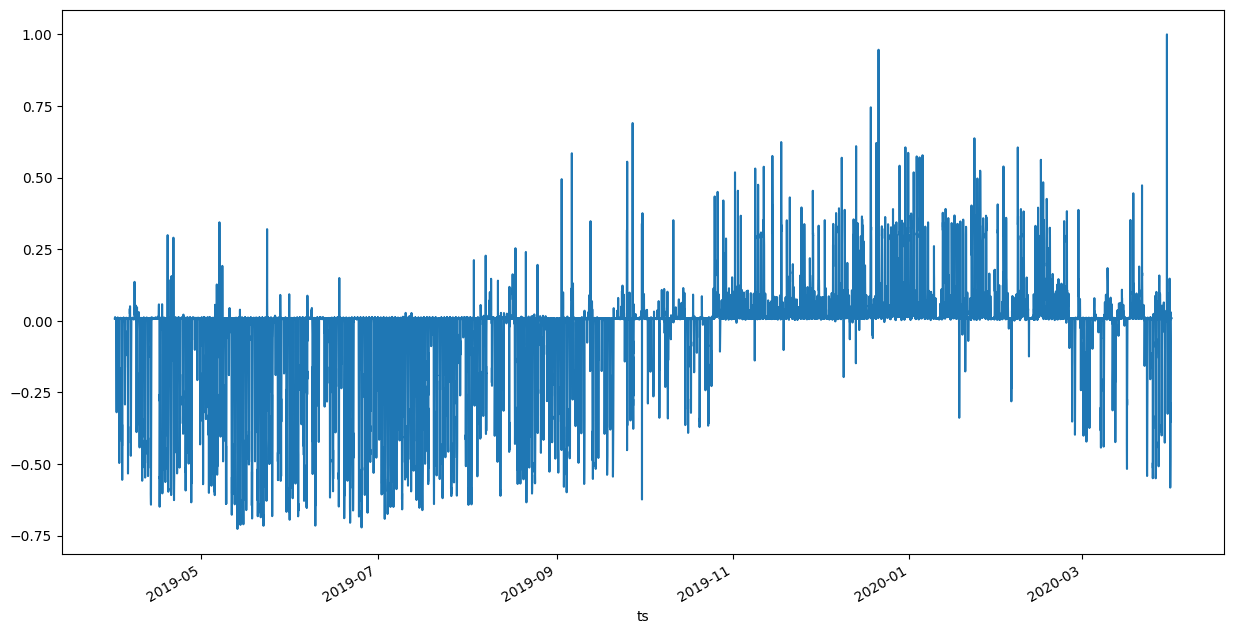

In [7]:
df['net_load_norm'] = df['net_load'] / max(abs(df['net_load']))
df.drop('net_load',axis=1,inplace=True)

plt.figure(figsize=(15,8))
df['net_load_norm'].plot()

## Data Preparation

In [8]:
lags = [1, 2, 48, 96]
for lag in lags:
    df[f'lag_{lag}'] = df['net_load_norm'].shift(lag)

In [9]:
df.dropna(inplace=True)

In [10]:
X = df[['lag_1', 'lag_2', 'lag_48', 'lag_96']].values
y = df['net_load_norm'].values

In [11]:
X_train, X_test = X[:-1440], X[-1440:]
y_train, y_test = y[:-1440], y[-1440:]

In [12]:
X_train.shape

(16003, 4)

In [13]:
y_train.shape

(16003,)

In [14]:
X_test.shape

(1440, 4)

In [15]:
y_test.shape

(1440,)

## Data Modelling

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import InputLayer, GRU, BatchNormalization, Dense
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError
from keras.metrics import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error

In [17]:
model = Sequential()
model.add(GRU(64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(8))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

2024-03-29 11:05:30.518922: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-03-29 11:05:30.518946: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-29 11:05:30.518950: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-29 11:05:30.518967: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-29 11:05:30.518979: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/adriachimenos/anaconda3/envs/aml_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. W

In [18]:
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10


2024-03-29 11:05:36.744907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


501/501 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - loss: 0.0091
Epoch 2/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 0.0048
Epoch 3/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - loss: 0.0046
Epoch 4/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - loss: 0.0042
Epoch 5/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - loss: 0.0042
Epoch 6/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - loss: 0.0040
Epoch 7/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - loss: 0.0038
Epoch 8/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - loss: 0.0039
Epoch 9/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - loss: 0.0040
Epoch 10/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - loss: 0.0040


In [19]:
def get_input(ts, lags):
    # Convert lags to positions from the end of the series
    positions = [-1 - lag for lag in lags]
    # Use numpy indexing to get values at positions
    return ts[positions].reshape(1,len(lags),1)

## Function for 36 Hour Prediction

In [ ]:
def get_predictions():
    predictions = []
    ts = y_train.copy()

    # Iterate over each timestamp in the test set
    for i in range(len(X_test)):
        x_input = get_input(ts,lags)
        pred_value = model.predict(x_input)
        ts=np.append(ts,pred_value)
        # Store the prediction
        predictions.append(pred_value)

    # Convert the list of predictions to numpy array
    predictions = np.array(predictions)

    # Reshape the predictions array if needed
    predictions = predictions.reshape(predictions.shape[0], 1)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='True Values')
    plt.plot(predictions, label='Predictions')
    plt.xlabel('Timestamp')
    plt.ylabel('Electricity Consumption')
    plt.title('Electricity Consumption Predictions')
    plt.legend()
    plt.show()

## Function for 30 Days

In [ ]:
def long_prediction():
    for day in range(0,30):
        pred_day = get_predictions(ts)
        full_predictions = full_predictions+pred_day
        ts = ts.append(X_test[72*day:72*(day+1)])